# FIRAS data fit

* Developed by Dhiraj Kumar Hazra, IMSc, Chennai, India

**A simple code to fit black body spectrum to the FIRAS data**

Data used from COBE results (available in https://lambda.gsfc.nasa.gov)

References:

1. Mather et. al. http://articles.adsabs.harvard.edu/pdf/1994ApJ...420..439M
2. Fixen et. al. https://iopscience.iop.org/article/10.1086/178173/pdf


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from matplotlib import rc
rc('text', usetex=True)

In [2]:
import constants as const

### Download the data

In [3]:
df=pd.read_csv(("https://lambda.gsfc.nasa.gov/data/cobe/firas/monopole_spec/firas_monopole_spec_v1.txt"), sep="\s+",skiprows=18,header=None)

In [4]:
df.head()

,0,1,2,3,4
0,2.27,200.723,5,14,4
1,2.72,249.508,9,19,3
2,3.18,293.024,15,25,-1
3,3.63,327.770,4,23,-1
4,4.08,354.081,19,22,3


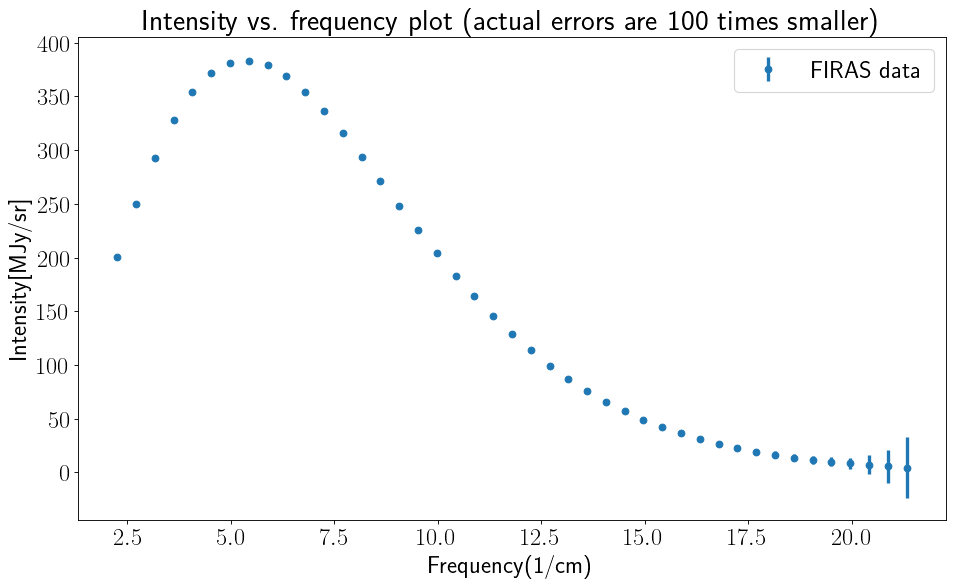

In [42]:
nu=df[0]
Inu=df[1]
dInu=df[3]/1000.0
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(nu,Inu,yerr=dInu*100.0, fmt='o',linestyle="",linewidth=3,
             label='FIRAS data')
plt.xlabel("Frequency(1/cm)")
plt.ylabel("Intensity[MJy/sr]")
plt.title('Intensity vs. frequency plot (actual errors are 100 times smaller)')
plt.legend()
plt.show()

## Define Black body spectrum

Fixen et. al. (https://iopscience.iop.org/article/10.1086/178173/pdf)


$$S(\nu;T,\mu)=\frac{2h\nu^3}{c^2}\frac{1}{e^{x}-1}$$


$$x=\frac{h\nu}{kT}$$

In [6]:
def bbspec(nu,T,mu=0):   
    # Takes nu in units of 1/cm
    # Returns spectra in MJy/sr
    #converting to 1/s
    nuHz=nu*const.Ccm  
    x=const.h*nuHz/(const.k_B*T)
    ThInu=(2.0*const.h*(nuHz**3.0)/(const.C**2.0))/(np.exp(x+mu)-1.0)
    #This is in Kg s^-2 units
    bbspec=ThInu/const.MJysrSI
    return bbspec

In [7]:
print(bbspec(5,2.73))

383.6323753790412


## Get the theoretical spectrum at T=2.7255 K

In [8]:
InuTh=np.zeros(len(nu))
T=2.7255
for i in range(len(nu)):
    InuTh[i]=bbspec(nu[i],T)

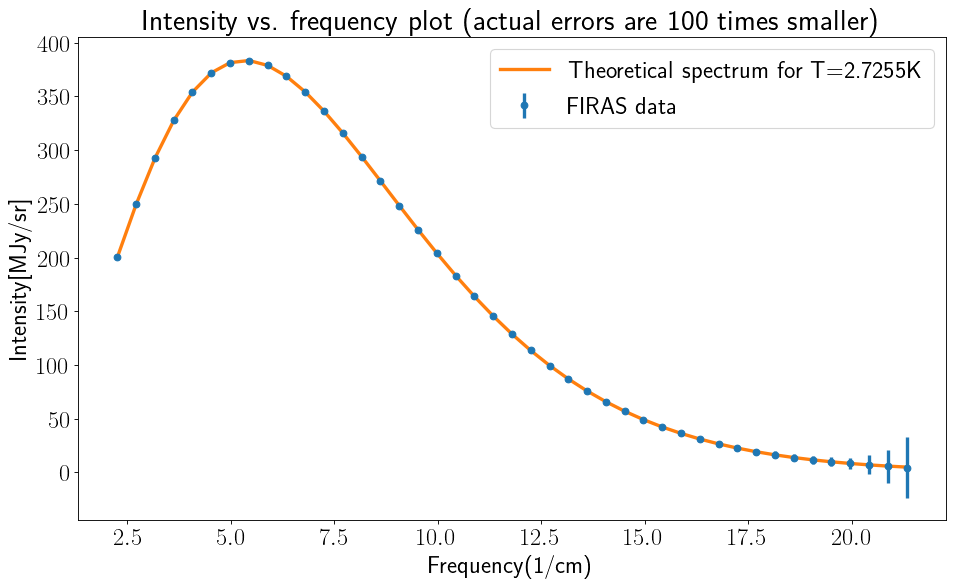

In [44]:
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(nu,Inu,yerr=dInu*100.0,fmt='o', linestyle="",
             label='FIRAS data',linewidth=3)
plt.plot(nu,InuTh,linewidth=3,label='Theoretical spectrum for T=2.7255K')
plt.xlabel("Frequency(1/cm)")
plt.ylabel("Intensity[MJy/sr]")
plt.title('Intensity vs. frequency plot (actual errors are 100 times smaller)')
plt.legend()
plt.show()

### Goodness of fit

Define $\chi^2$

In [10]:
# Define \chi^2

def chisq_simple(D,T,E):
    chisq_simple=np.sum(((D-T)/E)**2.0)
    return chisq_simple

In [11]:
def FIRAS_Chisq(params):
    T=params
    Th=np.zeros(len(nu))   
    for i in range(len(nu)):
        Th[i]=bbspec(nu[i],T)
        
    FIRASchisq=chisq_simple(Inu,Th,dInu)
    return FIRASchisq

In [12]:
from scipy.optimize import minimize


TCMB_bestfit=2.7
bestfit=minimize(FIRAS_Chisq,TCMB_bestfit)
print('Best-fit parameters:', bestfit['x'], '$\chi^2$', bestfit['fun'])

Best-fit parameters: [2.72501256] $\chi^2$ 45.09642288273006


In [13]:
print('Best-fit CMB temperature today is:', bestfit['x'][0], 'K')

Best-fit CMB temperature today is: 2.7250125614996645 K


In [14]:
def FIRAS_lnlike(params):
    T,mu=params
    Th=np.zeros(len(nu))
    for i in range(len(nu)):
        Th[i]=bbspec(nu[i],T,mu)
        
    FIRASchisq=chisq_simple(Inu,Th,dInu)
    lnlike=-0.5*FIRASchisq
    return lnlike

## Residual

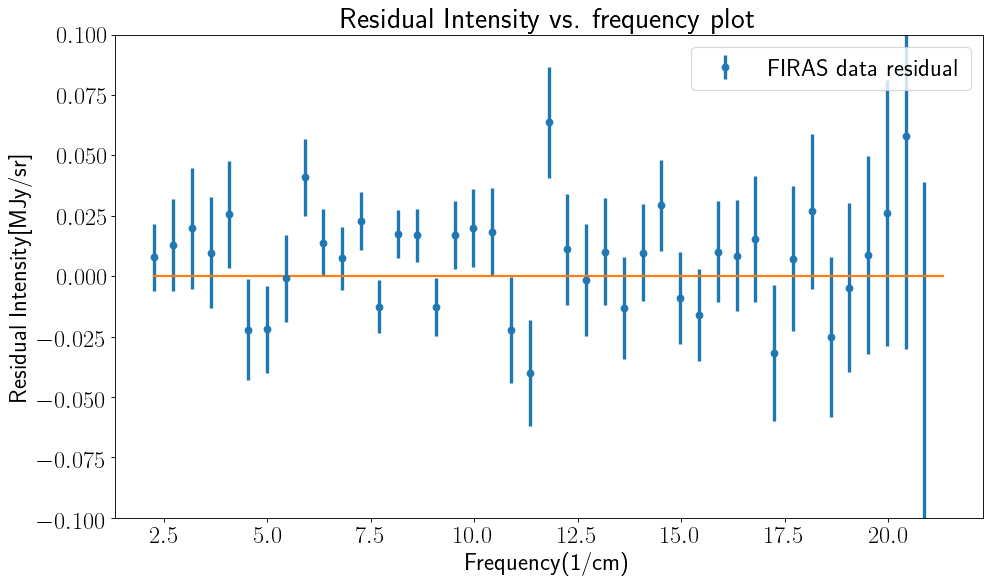

In [30]:
InuTh=np.zeros(len(nu))
T=bestfit['x'][0]
for i in range(len(nu)):
    InuTh[i]=bbspec(nu[i],T)
    
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(nu,Inu-InuTh,yerr=dInu,fmt='o',linestyle="",
             label='FIRAS data residual',linewidth=3)
plt.plot(nu,np.zeros(len(nu)),linewidth=2)
plt.ylim([-0.1,0.1])
plt.xlabel("Frequency(1/cm)")
plt.ylabel("Residual Intensity[MJy/sr]")
plt.title('Residual Intensity vs. frequency plot')
plt.legend()
plt.show()  

## Markov Chain Monte Carlo

Determine the distribution and bounds

100%|██████████| 500/500 [00:36<00:00, 13.54it/s]


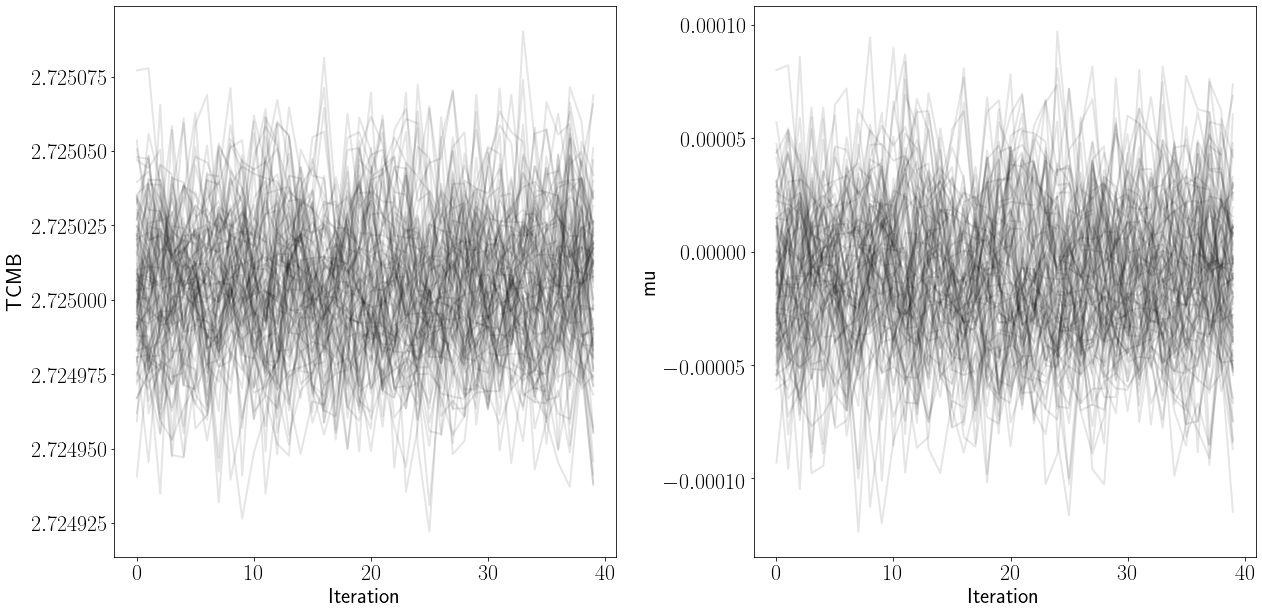

In [16]:
import emcee
# Use Bose-Einstein distributio

TCMB_bestfit=bestfit['x'][0]
mu_bestfit=1e-5
# initial points
ndim, nwalkers = 2, 100 
p0 = np.random.normal([TCMB_bestfit,mu_bestfit], 
                      [1e-7,1e-7],
                      size=(nwalkers, ndim))
# sample
niter = 500
sampler = emcee.EnsembleSampler(nwalkers, ndim, FIRAS_lnlike)
sampler.run_mcmc(p0, niter, progress=True);

params = ['TCMB', 'mu']
thin, discard = 10, 100
# plot traces of parameters
plt.figure(figsize=(18, 9))
for i in range(ndim):
    plt.subplot(1, 2, i+1)
    plt.plot(sampler.get_chain(thin=thin, discard=discard)[:, :, i]
    , color='black', alpha=0.1, lw=2)
    plt.xlabel('Iteration')
    plt.ylabel(params[i])
plt.tight_layout()

In [17]:
samples = sampler.chain[:, discard:, :].reshape((-1, ndim))
TCMB_1sigma, mu_1sigma = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(TCMB_1sigma, mu_1sigma)
TCMB_2sigma, mu_2sigma = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [2.5, 50, 97.5],
                                                axis=0)))
print(TCMB_2sigma, mu_2sigma)

(2.725004522493358, 2.3099417491678764e-05, 2.2668155700067416e-05) (-1.1723776142304848e-05, 3.219016480359803e-05, 3.0094475618442302e-05)
(2.725004522493358, 4.693546962242223e-05, 4.5087721967984606e-05) (-1.1723776142304848e-05, 6.381996493281111e-05, 6.077682785404033e-05)


## Monopole spectrum including possible deviations

We include the modification of Planck spectrum with the dimensionless chemical potential $\mu$. Compton distortion (Zeldovich, Sunyaev 1969) is parametrized by y. Galactic contamination is also added.

See Mather et. al. 1994 and  Fixen. et. al. 1996. While in these papers it is mentioned that -- We fit either the Kompaneets parameter or the chemical potential, but the two are too similar to fit simultaneously", here we allow , $T,\mu,y,G_0$ all four to vary. 

### Plot galactic contamination in the residual plane

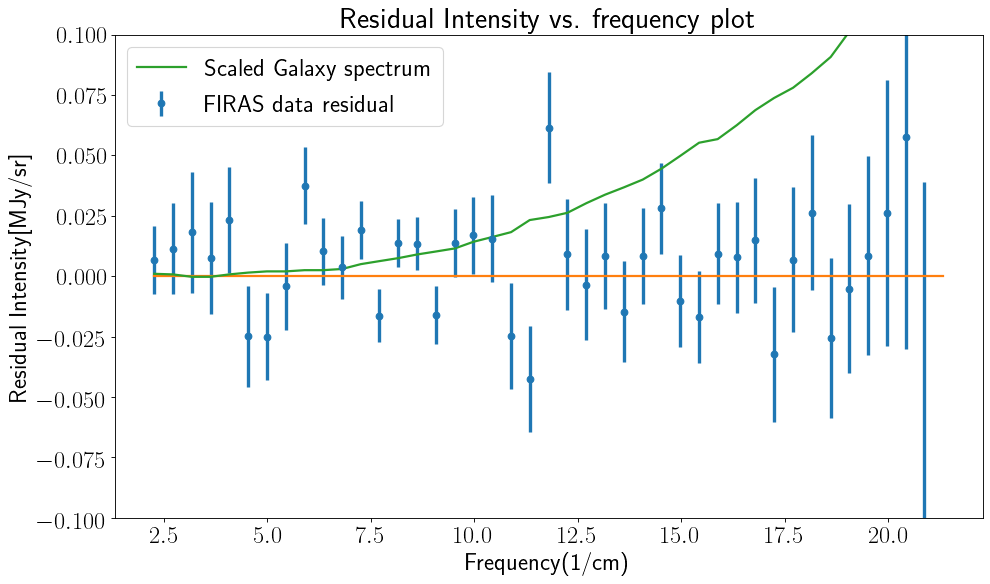

In [40]:
InuTh=np.zeros(len(nu))
# bestfit
T=2.725 
for i in range(len(nu)):
    InuTh[i]=bbspec(nu[i],T)
    
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(nu,Inu-InuTh,yerr=dInu,fmt='o',linestyle="",
             label='FIRAS data residual',linewidth=3)
plt.plot(nu,np.zeros(len(nu)),linewidth=2)
plt.plot(nu,0.25*df[4]/1000.0,linewidth=2,label='Scaled Galaxy spectrum')
plt.ylim([-0.1,0.1])
plt.xlabel("Frequency(1/cm)")
plt.ylabel("Residual Intensity[MJy/sr]")
plt.title('Residual Intensity vs. frequency plot')
plt.legend()
plt.show()  

In [18]:
def monopoles_spec(nucm,T,mu,y,G0,gnu):
    bbplanck=bbspec(nucm,T,mu=mu)
    #add the galactic spectrum with the amplitude
    bbplanckplusg=bbplanck+G0*gnu
    # Add the Compton distortion
    nuHz=nucm*const.Ccm  
    x=const.h*nuHz/(const.k_B*T)
    delsdely=bbplanck*x*np.exp(x)/(np.exp(x)-1)*((x/np.tanh(0.5*x))-4.0)
    monopole=bbplanckplusg+y*delsdely
    return monopole

In [19]:
monopole=np.zeros(len(nu))
gnu=df[4]/1000.0
T=2.725
mu=-1e-5
y=-1e-6
G0=1.0
monopole=monopoles_spec(nu,T,mu,y,G0,gnu)

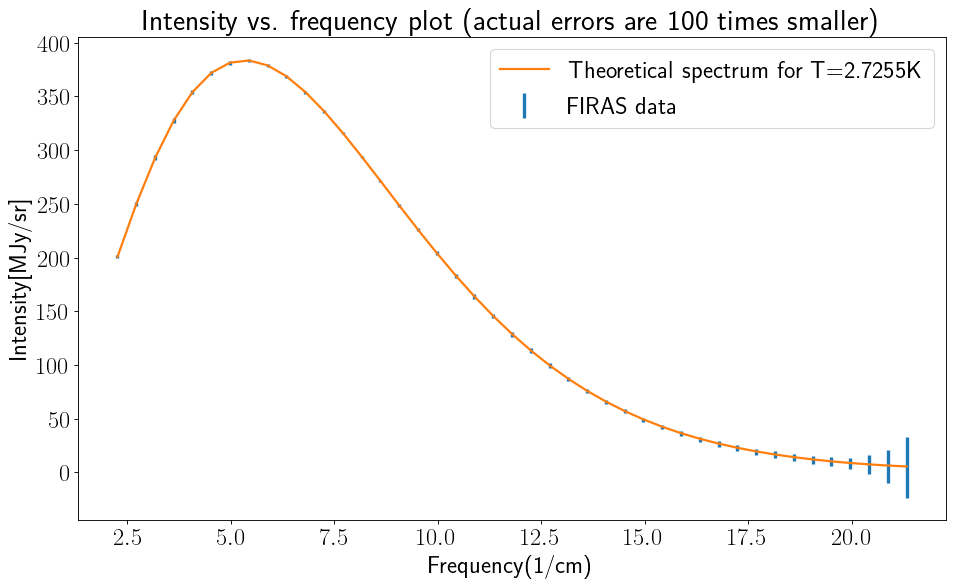

In [29]:
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(nu,Inu,yerr=dInu*100.0, linestyle="",
             label='FIRAS data',linewidth=3)
plt.plot(nu,monopole,linewidth=2,label='Theoretical spectrum for T=2.7255K')
plt.xlabel("Frequency(1/cm)")
plt.ylabel("Intensity[MJy/sr]")
plt.title('Intensity vs. frequency plot (actual errors are 100 times smaller)')
plt.legend()
plt.show()

In [21]:
def FIRAS_monopole_chisq(param):
    T,mu,y,G0=param
    if G0<0:
        return np.inf
    monopole=np.zeros(len(nu))
    monopole=monopoles_spec(nu,T,mu,y,G0,gnu)
    FIRASmonopolechisq=chisq_simple(Inu,monopole,dInu)
    return FIRASmonopolechisq

In [24]:
TCMB_bestfit=2.7
Tbestfit=2.725
mubestfit=-1e-5
ybestfit=-1e-6
G0bestfit=0.1
from scipy.optimize import Bounds
#bounds = ((2.6, 2.9),(-1e-4, 1e-4),(-1e-5, 1e-5),(0,1e-2))
bounds=Bounds([2.6,-1e-4,-1e-5,0],[2.9,1e4,1e5,1e-2])
monopoleparams=[Tbestfit,mubestfit,ybestfit,G0bestfit]
bestfit=minimize(FIRAS_monopole_chisq,monopoleparams,bounds=bounds)
print('Best-fit parameters:', bestfit['x'], '$\chi^2$', bestfit['fun'])

Best-fit parameters: [ 2.72499227e+00 -2.65489288e-05  1.64432058e-06  0.00000000e+00] $\chi^2$ 44.86965744816443


In [25]:
def FIRAS_monopole_Lnlike(param):
    FIRASmonopolelnlike=-0.5*FIRAS_monopole_chisq(param)
    return FIRASmonopolelnlike

  0%|          | 0/500 [00:00<?, ?it/s]/Users/dhiraj/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [02:34<00:00,  3.23it/s]


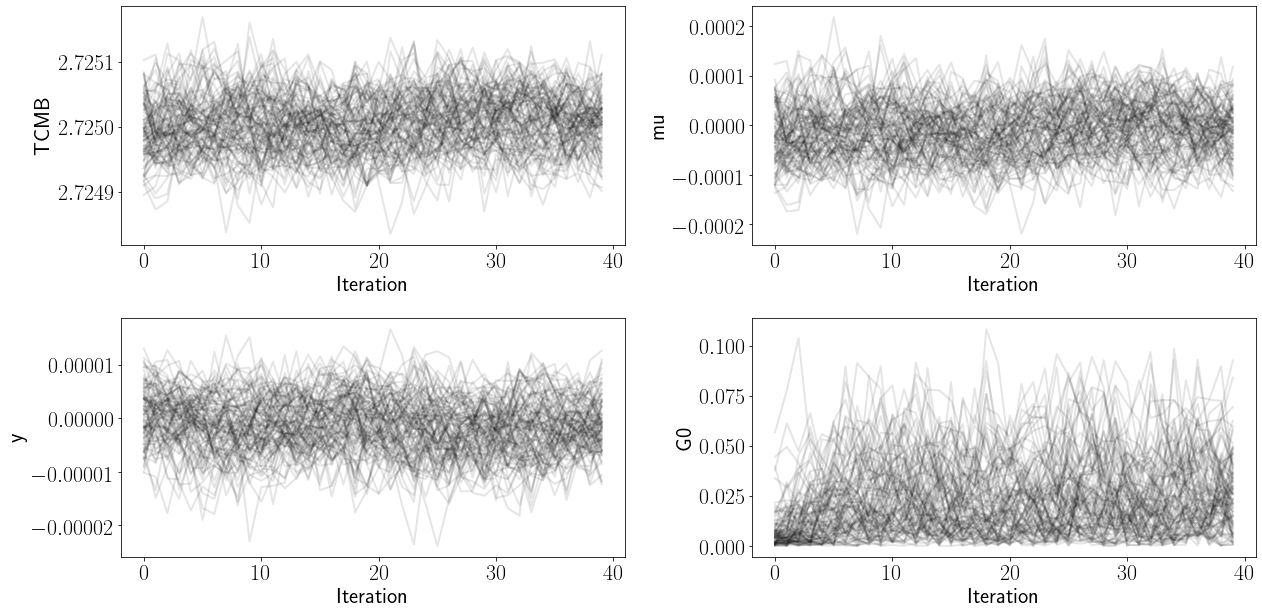

In [26]:
# initial points
ndim, nwalkers = 4, 100 
p0 = np.random.normal(bestfit['x'], 
                      [1e-7,1e-7,1e-7,1e-5],
                      size=(nwalkers, ndim))
# sample
niter = 500
sampler = emcee.EnsembleSampler(nwalkers, ndim, FIRAS_monopole_Lnlike)
sampler.run_mcmc(p0, niter, progress=True);

params = ['TCMB', 'mu','y','G0']
thin, discard = 10, 100
# plot traces of parameters
plt.figure(figsize=(18, 9))
for i in range(ndim):
    plt.subplot(2, 2, i+1)
    plt.plot(sampler.get_chain(thin=thin, discard=discard)[:, :, i]
    , color='black', alpha=0.1, lw=2)
    plt.xlabel('Iteration')
    plt.ylabel(params[i])
plt.tight_layout()

In [27]:
samples = sampler.chain[:, discard:, :].reshape((-1, ndim))
TCMB_1sigma, mu_1sigma,y_1sigma,G0_1sigma = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print('Mean and 1sigma uncertainties')
print(TCMB_1sigma, mu_1sigma,y_1sigma,G0_1sigma)
TCMB_2sigma, mu_2sigma,y_2sigma,G0_2sigma = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [2.5, 50, 97.5],
                                                axis=0)))
print('Mean and 2sigma uncertainties')
print(TCMB_2sigma, mu_2sigma,y_2sigma,G0_2sigma)

Mean and 1sigma uncertainties
(2.7250041328983334, 4.6686681018037746e-05, 4.427945033036451e-05) (-1.0143929112020333e-05, 5.8277191108551e-05, 5.729440519449973e-05) (-9.887960269228178e-07, 5.200789900540748e-06, 5.515045955618606e-06) (0.018123745488011704, 0.023532936889193543, 0.013622836753586852)
Mean and 2sigma uncertainties
(2.7250041328983334, 8.945997095599623e-05, 8.449614672878525e-05) (-1.0143929112020333e-05, 0.00011278610279912064, 0.00010879953760480686) (-9.887960269228178e-07, 9.95544237056352e-06, 1.1210297965946687e-05) (0.018123745488011704, 0.05148140700938932, 0.017519667392895198)
